In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

def get_clf_eval(model, X, y):
    confusion = confusion_matrix(y, model.predict(X))
    accuracy = accuracy_score(y, model.predict(X))
    precision = precision_score(y, model.predict(X))
    recall = recall_score(y, model.predict(X))
    F1 = f1_score(y, model.predict(X))
    AUC = roc_auc_score(y, model.predict(X))
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(y_true, y_prob, model_name):
    plt.figure(figsize=(8, 6))
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob) 
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data_feature_select.csv')

X = df.drop(['newDM'], axis=1)
y = df['newDM']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
categorical = [idx for idx, dtype in enumerate(X_train.dtypes) if dtype == 'int64']

# 오버 샘플링
smotenc = SMOTENC(categorical_features=categorical, random_state=42)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train, y_train)

scaler = StandardScaler()
scaler = scaler.fit(X_train_smotenc)
scale_trainX = scaler.transform(X_train_smotenc)

scaler = StandardScaler()
scaler = scaler.fit(X_test)
scale_testX = scaler.transform(X_test)

# TPOT

In [5]:
from tpot import TPOTClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [6]:
# 
tpot = TPOTClassifier(generations=3, population_size=20, verbosity=2, scoring='f1')
tpot.fit(X_train, y_train)

# 최적 파이프라인 추출
best_pipeline = tpot.fitted_pipeline_

# 스태킹 앙상블 모델 구성
estimators = [('tpot', best_pipeline)]


Optimization Progress:   0%|          | 0/80 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.41533625713656086

Generation 2 - Current best internal CV score: 0.41533625713656086

Generation 3 - Current best internal CV score: 0.41533625713656086

Best pipeline: BernoulliNB(ExtraTreesClassifier(StandardScaler(input_matrix), bootstrap=True, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=8, min_samples_split=2, n_estimators=100), alpha=100.0, fit_prior=False)


In [13]:
estimators = [('tpot', best_pipeline)]
stacked_ensemble = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())
stacked_ensemble.fit(X_train_smotenc, y_train_smotenc)

StackingClassifier(cv=None,
                   estimators=[('tpot',
                                Pipeline(memory=None,
                                         steps=[('standardscaler',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True)),
                                                ('stackingestimator',
                                                 StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=True,
                                                                                                  ccp_alpha=0.0,
                                                                                                  class_weight=None,
                                                                                                  criterion='gini',
                                                                                                  max_depth=None,
                                                                                                  max_features=0.9000000000000001,
                                                                                                  max_leaf_nodes=None,...
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_depth=None,
                                                          max_features='sqrt',
                                                          max_leaf_nodes=None,
                                                          max_samples=None,
                                                          min_impurity_decrease=0.0,
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
                                                          min_weight_fraction_leaf=0.0,
                                                          n_estimators=100,
                                                          n_jobs=None,
                                                          oob_score=False,
                                                          random_state=None,
                                                          verbose=0,
                                                          warm_start=False),
                   n_jobs=None, passthrough=False, stack_method='auto',
                   verbose=0)

오차행렬:
 [[2056  527]
 [ 152  274]]

정확도: 0.7743
정밀도: 0.3421
재현율: 0.6432
F1: 0.4466
AUC: 0.7196


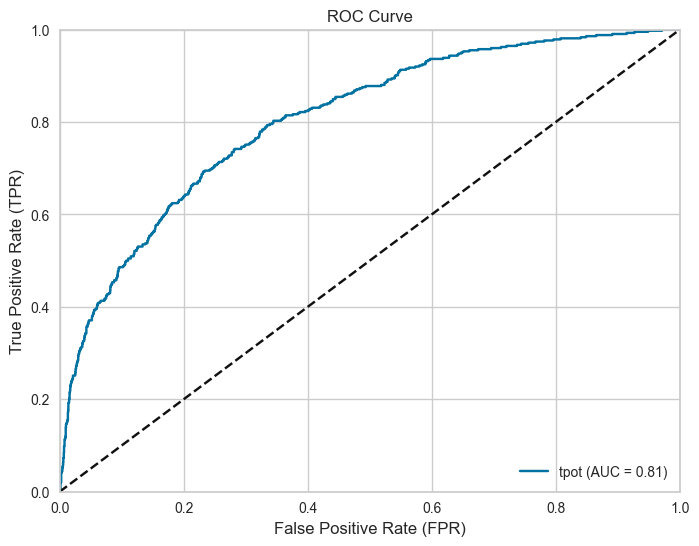

In [17]:
y_pred= tpot.predict(X_test)
y_probs = tpot.predict_proba(X_test)[:, 1]
get_clf_eval(tpot, X_test, y_test)
plot_roc_curve(y_test, y_probs, 'tpot')

오차행렬:
 [[2000  583]
 [ 161  265]]

정확도: 0.7527
정밀도: 0.3125
재현율: 0.6221
F1: 0.4160
AUC: 0.6982


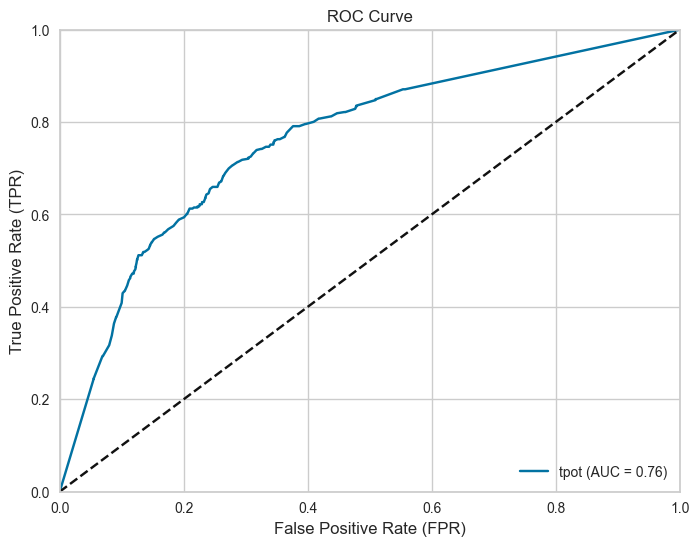

In [18]:
y_pred= stacked_ensemble.predict(X_test)
y_probs = stacked_ensemble.predict_proba(X_test)[:, 1]
get_clf_eval(stacked_ensemble, X_test, y_test)
plot_roc_curve(y_test, y_probs, 'tpot')

# Pycaret

In [9]:
from pycaret.classification import *

data = pd.concat([X_train_smotenc, y_train_smotenc], axis=1)
categorical_data = list(X_train.select_dtypes(include='int').columns)  
clf_setup = setup(data=data, target='newDM', train_size=0.8, preprocess=False, categorical_features=categorical_data)

best_model = compare_models(n_select=5)



,Description,Value
0,Session id,4451
1,Target,newDM
2,Target type,Binary
3,Original data shape,"(11988, 28)"
4,Transformed data shape,"(11988, 28)"
5,Transformed train set shape,"(9590, 28)"
6,Transformed test set shape,"(2398, 28)"
7,Numeric features,16
8,Categorical features,11


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9185,0.9733,0.8951,0.9391,0.9164,0.8369,0.8380,1.9190
xgboost,Extreme Gradient Boosting,0.9178,0.9731,0.9009,0.9325,0.9164,0.8357,0.8363,0.7930
lightgbm,Light Gradient Boosting Machine,0.9166,0.9733,0.8945,0.9359,0.9146,0.8332,0.8342,0.7660
rf,Random Forest Classifier,0.9024,0.9677,0.9232,0.8865,0.9044,0.8048,0.8057,0.9660
et,Extra Trees Classifier,0.8944,0.9627,0.9185,0.8764,0.8968,0.7887,0.7899,0.7580
gbc,Gradient Boosting Classifier,0.8869,0.9553,0.9018,0.8760,0.8885,0.7737,0.7744,0.9890
dt,Decision Tree Classifier,0.8511,0.8511,0.8598,0.8452,0.8524,0.7022,0.7025,0.6430
ada,Ada Boost Classifier,0.8322,0.9121,0.8605,0.8147,0.8368,0.6644,0.6658,0.6960
knn,K Neighbors Classifier,0.8186,0.9143,0.9693,0.7448,0.8424,0.6371,0.6683,0.6020
lda,Linear Discriminant Analysis,0.7748,0.8440,0.8434,0.7418,0.7892,0.5495,0.5550,0.6020


In [10]:
stacked_model = stack_models(estimator_list=best_model, meta_model = create_model('rf'))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9155,0.9691,0.9292,0.9047,0.9168,0.8311,0.8314
1,0.9051,0.9717,0.9417,0.8777,0.9085,0.8102,0.8124
2,0.9114,0.9716,0.9062,0.9158,0.9110,0.8227,0.8228
3,0.8926,0.9683,0.9208,0.8718,0.8956,0.7852,0.7864
4,0.9041,0.9714,0.9417,0.8760,0.9076,0.8081,0.8104
5,0.9041,0.9674,0.9207,0.8909,0.9055,0.8081,0.8086
6,0.9187,0.9709,0.9395,0.9018,0.9202,0.8373,0.8381
7,0.8863,0.9596,0.9040,0.8730,0.8882,0.7727,0.7732
8,0.8978,0.9695,0.9165,0.8833,0.8996,0.7956,0.7962


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9322,0.9853,0.8979,0.9642,0.9299,0.8645,0.8665
1,0.9218,0.9804,0.9042,0.9374,0.9205,0.8436,0.8441
2,0.9270,0.9789,0.8792,0.9724,0.9234,0.8540,0.8580
3,0.9270,0.9841,0.8896,0.9617,0.9242,0.8540,0.8564
4,0.9458,0.9881,0.9292,0.9612,0.9449,0.8916,0.8921
5,0.9333,0.9830,0.8935,0.9705,0.9304,0.8665,0.8693
6,0.9364,0.9851,0.9081,0.9624,0.9345,0.8728,0.8742
7,0.9364,0.9797,0.9144,0.9563,0.9349,0.8728,0.8736
8,0.9406,0.9868,0.9081,0.9710,0.9385,0.8811,0.8830


In [11]:
stacked_model

StackingClassifier(cv=5,
                   estimators=[('CatBoost Classifier',
                                <catboost.core.CatBoostClassifier object at 0x000002041C95FD60>),
                               ('Extreme Gradient Boosting',
                                XGBClassifier(base_score=None, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              featu...
                                                          ccp_alpha=0.0,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_depth=None,
                                                          max_features='sqrt',
                                                          max_leaf_nodes=None,
                                                          max_samples=None,
                                                          min_impurity_decrease=0.0,
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
                                                          min_weight_fraction_leaf=0.0,
                                                          n_estimators=100,
                                                          n_jobs=-1,
                                                          oob_score=False,
                                                          random_state=4451,
                                                          verbose=0,
                                                          warm_start=False),
                   n_jobs=-1, passthrough=True, stack_method='auto', verbose=0)

In [12]:
get_clf_eval(stacked_model, X_test, y_test)

오차행렬:
 [[2508   75]
 [ 324  102]]

정확도: 0.8674
정밀도: 0.5763
재현율: 0.2394
F1: 0.3383
AUC: 0.8220


# Autogluon

In [15]:
import autogluon as ag
from autogluon import TabularPrediction as task

predictor = task.fit(train_data=scale_trainX, label=y_train_smotenc, problem_type='classification',
                     eval_metric='AUC', stack_ensemble_levels=2)

# 테스트 데이터 예측
y_pred = predictor.predict(X_test)

# 성능 평가
get_clf_eval(y_test, y_pred)

type: cannot import name 'TabularPrediction' from 'autogluon' (unknown location)